<a href="https://colab.research.google.com/github/amcheyre-nw/DL_Object_detection/blob/main/Faster_RCNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download TorchVision repo to use some files from references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 97540, done.
remote: Counting objects: 100% (32671/32671), done.
remote: Compressing objects: 100% (2590/2590), done.
remote: Total 97540 (delta 30186), reused 32110 (delta 29911), pack-reused 64869
Receiving objects: 100% (97540/97540), 192.88 MiB | 40.02 MiB/s, done.
Resolving deltas: 100% (83265/83265), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
# Install libraries
! pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.0 MB/s 
     |████████████████████████████████| 948 kB 36.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=4270221ec36c46a88b69080b4cac9683279729fc6cea2e8682e3812a40b9cdd4
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
# Python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2
import json

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations (not working this)
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## BBD100K Dataset

In [4]:
# Import database
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [41]:
# defining the files directory and testing directory
files_dir = '/content/drive/MyDrive/BDD100K/sample_train'
test_dir = '/content/drive/MyDrive/BDD100K/sample_val'



In [76]:
class SelfDrivingCarDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(self.files_dir)) if image[-4:]=='.jpg']
        
        # classes: 0 index is reserved for background
        # classes bike -> bicycle, motor -> motorcycle, pedestrian -> person (check in COCO)
        self.classes = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motor', 'bike',
                        'traffic light', 'traffic sign']

    def __getitem__(self, idx):
        cv2.setNumThreads(0)
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        if self.files_dir == files_dir:
          annot_filename = 'bdd100k_labels_images_train.json'
          annot_file_path = '/content/drive/MyDrive/BDD100K/bdd100k_labels_images_train.json'
        else:
          annot_filename = 'bdd100k_labels_images_val.json'
          annot_file_path = '/content/drive/MyDrive/BDD100K/bdd100k_labels_images_val.json'

        json_file = open(annot_file_path)
        train_data = json.load(json_file)
        
        boxes = []
        labels = []
        images = []
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for json file are extracted and corrected for image size given
        for image in train_data:
          # check if image json is in image files
          if image['name'] in self.imgs:
            images.append(image['name'])
            labels.append(self.classes.index(image['labels'][0]['category']))
            
            # bounding box
            xmin = image['labels'][0]['box2d']['x1']
            xmax = image['labels'][0]['box2d']['x2']
            
            ymin = image['labels'][0]['box2d']['y1']
            ymax = image['labels'][0]['box2d']['y2']
            print(xmin)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        print(boxes)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = SelfDrivingCarDataset(files_dir, 1280, 720)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
#print(img.shape, '\n',target)

length of dataset =  210 

419.245359
500.015359
929.413886
550.620761
660.044072
594.231618
256.812699
557.945587
204.18736
173.437812
593.38418
1.247754
479.924832
645.269
806.735958
435.841307
700.373739
586.4444
566.999802
592.544118
533.119367
265.679979
996.46207
26.701937
591.166444
1.741176
615.367402
689.418662
635.626948
128.519991
1167.62492
867.053467
297.231822
1.247754
670.169064
502.843307
555.647397
0
918.11053
0.997945
442.952685
687.512478
433.484608
580.035087
615.840732
437.111743
967.604337
691.978169
837.389164
1013.656926
669.159042
612.543947
631.799779
733.570289
629.09978
37.921957
1013.561582
296.511823
703.967146
626.435336
797.837142
747.794012
677.356001
749.481511
912.442619
330.660247
0.814284
836.272881
378.243149
338.665249
358.821438
632.068277
1.0926
563.956959
3.919354
621.057635
0
776.048674
617.856601
298.040274
226.533793
1032.103624
740.989001
641.556747
472.786343
412.878752
318.909347
550.356649
0
1067.165351
661.73157
739.555271
94.499934
310

## Visualization of bounding boxes

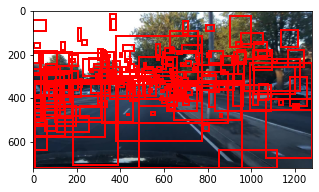

In [6]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)

# Load the pre-trained model Fast RCNN

In [7]:
# Pre-trained model
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

# Data Augmentation

In [8]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Preparing dataset

In [9]:
# NEED TO WORK ON THIS
# use our dataset and defined transformations
dataset = SelfDrivingCarDataset(files_dir, 1280, 720, transforms= get_transform(train=True))
dataset_test = SelfDrivingCarDataset(files_dir, 1280, 720, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


# Training the model

In [10]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 10

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [57]:
# training for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

KeyboardInterrupt: ignored

# Decoding predictions

In [49]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Test the model

In [56]:
# pick one image from the test set
img, target = dataset_test[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

RuntimeError: ignored

EXPECTED OUTPUT


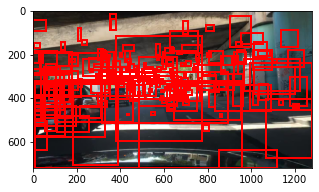

In [38]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

NMS APPLIED MODEL OUTPUT


TypeError: ignored

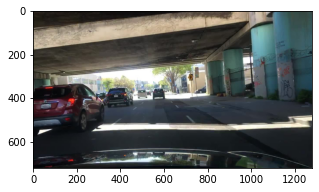

In [50]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
#plot_img_bbox(torch_to_pil(img), nms_prediction)

In [73]:
test_dataset = SelfDrivingCarDataset(test_dir, 1280, 720, transforms= get_transform(train=True))
# pick one image from the test set
print(test_dataset[10])
img, target = test_dataset[10]
print(test_dataset[10])
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

this is file name bdd100k_labels_images_val.json
b1ceb32e-51852abe.jpg
1000.698742
819.464053
648.239401
623.59743
424.791155
448.485931
339.3891
619.398392
603.568995
937.813727
874.356425
654.245214
610.122794
415.356741
591.279907
220.622476
0
62.268335
645.612619
132.207813
319.169306
765.12544
382.931668
750.385156
570.833756
707.30834
354.606782
16.220803
356.288719
644.856583
673.787183
516.606671
332.320214
952.036335
547.764025
500.849824
574.598273
185.349648
899.668863
523.72129
82.65829
1108.718258
794.807529
536.89507
435.46616
660.909633
1050.837376
0
708.724296
373.484793
395.674492
0
350.618886
0
1.082859
577.356629
485.001865
15.941519
690.852812
261.794347
590.856621
579.853735
567.306757
613.721741
573.981632
1186.916332
753.643443
0
2.840803
417.37334
611.39948
707.389925
120.580505
584.106626
434.969144
1079.184225
336.643374
48.344196
815.293966
417.820481
362.25448
1002.968538
633.319651
270.000121
514.950327
643.592092
859.702535
226.361909
744.29604
74.226816
3

RuntimeError: ignored